# TD 4

[Use pytorch for all questions]

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

## Width vs Depth: Theory

### Function of interest

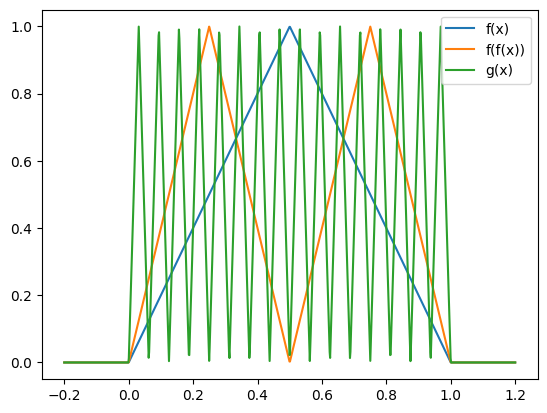

In [2]:
def f(x):
    return 1-(2*np.abs(x-0.5)).clip(0,1)

x = np.linspace(-0.2, 1.2, 1000)
y = f(x)
plt.plot(x, y, label="f(x)")
y = f(f(x))
plt.plot(x, y, label="f(f(x))")
# y = f(f(f(x)))
# plt.plot(x, y, label="f(f(f(x)))")

def g(x, lvl=5):
    for i in range(lvl):
        x = f(x)
    return x

y = g(x)
plt.plot(x, y, label="g(x)")
plt.legend()
plt.show()

Define a basic "rectange" network class (width is the same in all hidden layers);
leave the number of layers and number of neurons per layer as parameters, and use ReLU activation function.
The input and output are 1D, since we fit functions $\mathbb{R} \to \mathbb{r}$.

With 4 hidden layers and 5 neurons per layer, your network class should create a network as follows:

![rectangle network diagram](../images/rectangle_network.svg)